In [27]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [28]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [29]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import desc

In [30]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [31]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/bf/xgqv3_j16z344627n42tj1lc0000gn/T/ipykernel_44265/4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [32]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [33]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [34]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [35]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date

'2017-08-23'

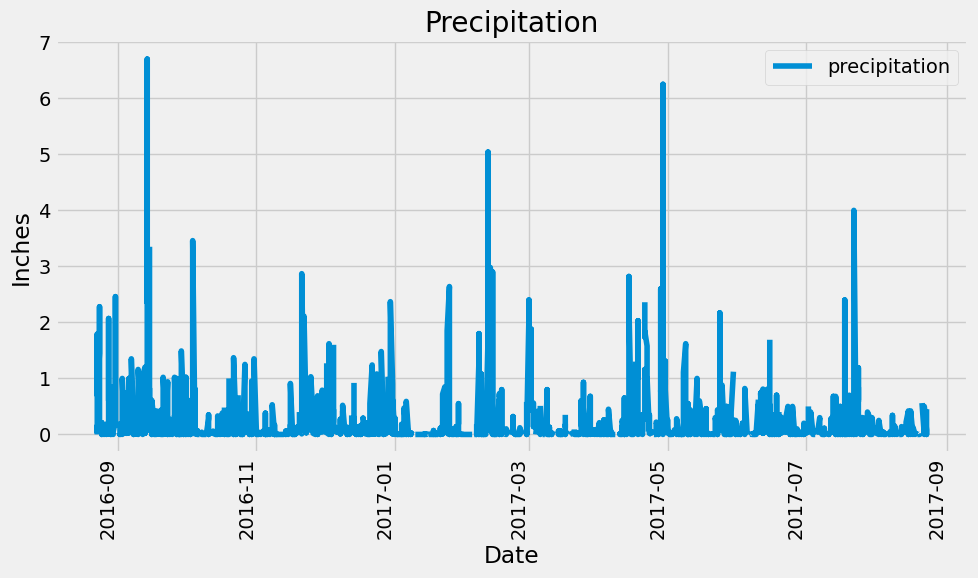

In [36]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)
one_year_ago = one_year_ago.strftime('%Y-%m-%d') 

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_data = pd.DataFrame(results, columns=['date', 'precipitation'])
precip_data['date'] = pd.to_datetime(precip_data['date'])


# Sort the dataframe by date
precip_data = precip_data.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
precip_data.set_index('date', inplace=True)
precip_data.plot(y='precipitation', figsize=(10, 6), legend=True)
plt.title('Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [37]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_summary = precip_data['precipitation'].describe()
print(precip_summary)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [38]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
total_stations

9

In [42]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station)\
    .order_by(desc(func.count(Measurement.station))).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [52]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0] if most_active_stations else None
if most_active_station_id:
    temperature_stats = session.query(
        func.min(Measurement.tobs).label('min_temp'),
        func.max(Measurement.tobs).label('max_temp'),
        func.avg(Measurement.tobs).label('avg_temp')
    ).filter(Measurement.station == most_active_station_id).all()
    min_temp, max_temp, avg_temp = temperature_stats[0] if temperature_stats else (None, None, None)

temperature_stats

[(54.0, 85.0, 71.66378066378067)]

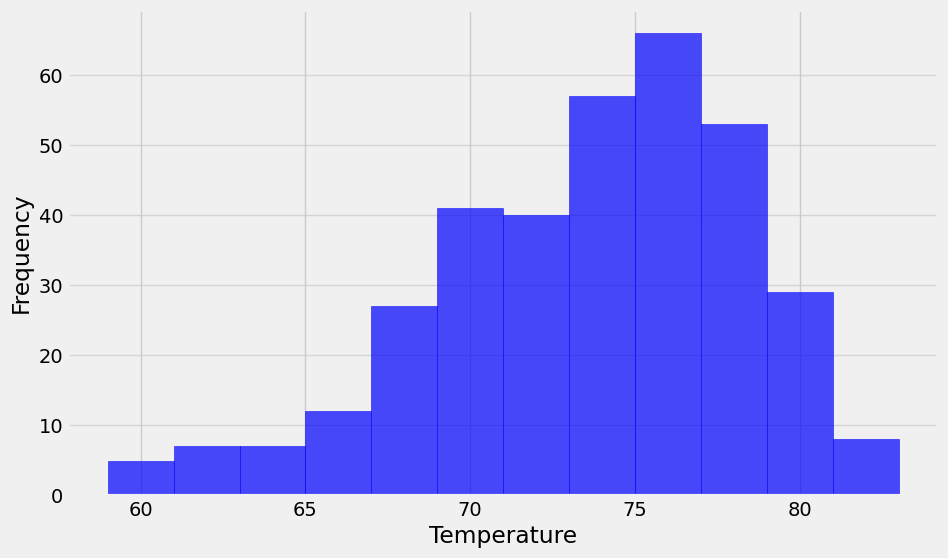

In [56]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
if most_active_station_id:
    temperatures_last_year = session.query(Measurement.tobs).filter(Measurement.station == most_active_station_id)\
        .filter(Measurement.date >= one_year_ago).all()
    temperature_values = [temp[0] for temp in temperatures_last_year]
    if temperature_values:
        # Plotting the histogram
        plt.figure(figsize=(10, 6))
        plt.hist(temperature_values, bins=12, color='blue', alpha=0.7, edgecolor='blue')
        plt.xlabel('Temperature')
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.show()
    else:
        print("No temperature data found for the last 12 months.")


# Close Session

In [57]:
# Close Session
session.close()